# Demo - Probabilistic Fourier with AR model on coefficients

This file provides an demo of the probabilistic Fourier framework as outline in "Bayesian spectrum estimation of unevenly sampled data" - Qi et al.

$$ {\bf{s}}_t = {\bf{s}}_{t-1} + {\bf{w}}_t $$
$$ {\bf{y}}_t = C^\top {\bf{s}}_t + {\bf{v}}_t $$

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using FFTW
using LAR
using LAR.Node
#using LAR.DataAR

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
;

## Settings

In [2]:
# data loading
sound_file1 = "../data/obama.wav"   # specify sound location
sound_file2 = "../data/drilling.wav"   # specify sound location
fs_desired = 8000                  # specify desired sampling frequency

# input buffer parameters
step_size = 1                      # specify step size of buffer
buffer_size = 32                    # specify size of buffer

# probabilistic fourier parameters 
var_observation = 1e-3               # specify observation noise var
var_x = 1e0
freq_bins = 15
freq = collect(fs_desired/(2*(freq_bins+1)):fs_desired/(2*(freq_bins+1)):(fs_desired/2-fs_desired/(2*(freq_bins+1))))

# AR modelling
AR_order = 5
iterations = 5

# load model parameters
load_file1 = "../inferred_values/all_speech_AR05_15freqs.h5" # file in which model parameters are present
load_file2 = "../inferred_values/all_drilling_AR05_15freqs.h5" # file in which model parameters are present
;

## Load data

In [3]:
# load and process speech signal
x_time1, fs_time1 = wavread(sound_file1, format="native")
fs_time1 = Int(fs_time1)
x_time1 = x_time1[24*fs_time1+1:27*fs_time1]
x_time1 = resample(x_time1, fs_desired/fs_time1)
x_time1 = 100*x_time1/var(x_time1)

# load and process speech signal
x_time2, fs_time2 = wavread(sound_file2, format="native")
fs_time2 = Int(fs_time2)
x_time2 = x_time2[24*fs_time2+1:27*fs_time2]
x_time2 = resample(x_time2, fs_desired/fs_time2)
x_time2 = 100*x_time2/var(x_time2)

x_tot = vcat(zeros(32), x_time1 + x_time2)

# specify time axis
t = collect((1:length(x_time1))/fs_desired)

# create audioplayer
audioplayers(x_time1, x_time2, x_tot, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBGmbQ8fipHPduSKj2LnQQ9f8icPAh4ETy2sAu8jBPOvBMsCr3VU/G8OWa0vF/NHbxh1zu79oG+O9VYmTsgK+g7rZBtPBCmejyUuII8bnWHPCwYjTzxfoI8dkDZO3msObw7Aee8Yc4FvaN0Gr3fdf68o+ePvHdxlLsfipA8w+YqPYEabT3DYYQ9fx5xPc3PRj1tBSg9x5wNPV9t3Dx8pMg8cDeZPM+UqDv3YCm8XHSKvFcleLwyCWu8KjkIvDoVFDt8h3Q5IPqhOzkMszzvExU9gI02PVIbIz1vsd48at6nO5hQrbxJySK9IzVavSOLiL0eHpO90gR3vYnNNr2XSMu8Yn+Ju25iRjy/scA8bUaJPJ8u/TsmzL+7IH5vvKUr+rxxzSG9nrMYvdHs3rwFdIS8rFAyvGFTdbxL3y68UcZhutQcZzvA/W48W9CIPK62tjw/ja88Lmx5PDwJcjsN1kq8To4NvalBQr3Jdk698i88vRnh/rxZ1kW8fGvlO5wfyDw9QCI9O0A/PcMNMD118ew8eGsfPDGViLo1YS28CNi8vMJEH73MCVO9eq9tvSJTab0zEEi9J17cvAIvO7xMewA69rYFPMNogTxX5aU8SeKfPHd7lTy377g8btrsPAHc/jxu9sU8vgz4O8BhK7w8ury8lB/JvG2AsLwCwpO8B8cevK2GaDulRqI8rswfPfpgST1iYUU97UkdPYjrpzxbVoC7v3vSvBj9IL0Xyj69PQRTvT9OXr14u2u9WDFsvXdCWb3kLjK9tHfevOsYiLxDcdK7GZeDu0DmJDt1j7Q7CZBjO+QxAbvjvA+87tbJvF3M9ry8cw+9fzUQvUmIpbx0V9g72PkUPfHAWT1Hnno94Y1vPZsCOz3NbwY9tna2PEnbBjwkeCq8/o8CvazBOb3+pDm9zJAavebK7LwoKI28IA0tvI7aIbz42pi7JIDNO9HsizwQzbc8oaPGPGGd3jy4Y8k8znoYPPs/aLyPoRe94EtIvVR8Zr2QlGC9vYMSvaSVG7zGZYM87SkOPY5ePj1ozW49F5CBPY8SWD1aTjM92Lr9PKGnjjzt7l08XYlRPJ5tYTySjj08VXGiO79unLoZ2p66JWybO4/XgDywTak8wbSvPGMyyDyI0Oo8kwQdPbeXOD3+7xY9LfAbPPCQi7xjT/q8niUuvfdaV70jA3q9DOdcvV3BNb1GlNi89YbWu4wWXDxV7bk8/z+OPEyWOzyeRIQ75fzIu/AanLwu9xG9lYo7vXPeRL3/+Cm9p1PWvIqzC7wXHo47xDU7PNfkHDwYl+I7wdT0Oyvg3jsVuFY7b/XTukhW/rsod7e8ajQhvZqKUL2iImu9FvRtvW/hUL1arRi9p7iCvCx2wDtkILw8Okw8PUEHdD0pM109zeMMPc7vZDy5fEg706iVu2QbWLxvdKW8aoa1vF7Zwrwf4Oy8w60BvRP2z7z1s268yUOxux8/DTzcn4Y8bsevPB960DxuUNo8tHzyPNoV4TxbKnM89nsGPIQvxztC94G7WQ7zu+iO47t8JAy7aeAnPMxhsTx85wo9wQAlPfFWGz2/qR09t8kaPb3P/Dxj8ZQ82OE1u+sTkbxTLce8GWb3vLovBb1otSO9TI81vTANN71kWi69WDgNvRgs87yZ5sS85B1cvItUO7sva4o7Ss2VuTOvg7z0NQa9utlDvZ3hbb0zPWq9Dd9Bvb/IBL0hJn+8vaO0O/yhwjxdsio9vA0+PZ8lJD1uwNI8JZ0hPJsY/DqulDq8jurzvJU4Fb0iJwW9gWnwvJALtrypkJC8+3gJvHkamDiv17U7O4QhPEAxkjyqqcI8nYDZPJHB2DxQHdE8EfWjPKTlCzxtODK82vQLvZQ7Ur24H3G9M/tlvZqvM70qHNq8ae8HvFhNKTwDMgA956QiPTjrDD0oW7E8V3IIPEwBtbqWCA28B7MvvNUXs7vK0n06uayUOh9TSzs/pvg6U1YCu/J3gjq/Akc7/EQRPD9uTTy9S8Y8CHQePVjuVj2twl49ejcUPZlPNTyg9XS8Bn4cvW/NXr3xkoK9kYtqvQIHJL3lgq+8ILZaudWXnjzrFP08XcEEPYBU4DwSrpg8jwnuO9/SpLvXW0W8bT2CvLPoTLyRrES8zeEqvAp7mLqMVo87jnROPCWFqzypuKs8JQiTPNFlsjzDP708nLelPEwSkTwiUg08bny3u3TWmLxNIe28I/gLvfIZG70zNRi9Nm3ZvKwOlruxTtA8oOg+PXcCZD3arUo9gCsAPa9roDw5zoM8IMRIPOFPYjsKHse7sGlsvP5doLyaBqW8WIKMvFP/k7yW5ai8g4SCvKvAGrw1qQw6qy9vPLmP4Dz3zBI9z8oYPfNa4DxoyYY8EbAKu/8DiLwzb+W8NTodvZDmJL1Yqiy9rR4Mve19obwK+du7WHcQPN4ciTwAEXc8/eFnPNchIjw5s6Q7OjMGu28KWLyTrOG8XSsPvcRiKL0b6SW97pYgvQLsI7070RC9fTYGvb4Lx7z9W1a8QDzju5MRRjp3eSI7eg7BuUEB+Lu6aLS8+VMAvTeqPr39SXO9OGGAvY0YV72Ry+C8B+uiORCmqzwgSQU92dENPZ8qDj1M5+Q8DMSIPE1NpDqWiD28unWQvN1Ocbwalsq6jvkrOx48QzuuZ2474inKOkLc5zs+Cyo8ImYGPHdn+js10+I62oAXO1g5LTtQ2Zw6mUHpu3SsobxNJwW9bstIvYwMdL0HiZC9avOUvU6Gj71MamS9SJ4BvTS/lbsaHaU8qczzPJfxCj2XajA9RrNoPW1rkD0f4aE9qPe2Pfzivz1yOsk91EvTPWpbyT3VH7M9L36SPfh6aD3GQys9eeTcPB9+KTw7rOc6Bt76uvOsmruMQxC8hqatvD6+LL3/X2u94TOLvfvunr2P+qu9tqG2vdvyrL1PWJC9cgRHvZ+r9Lx0oYa8Iz7yu+N3qbjfdqs7ba8nPFDojjzIH7A8XqnfPBPA+TyRdwI9ZUsGPTbeET3y+iE9AqkkPdibEj2+Mtc8y+6dPBHHUjy1VoI550Y/vB+Gu7yySSe9ONJ3veYOoL37Gru9AhW9vfqMt70zmKO9xjtrvZn23Ly2bLc7yIX9PB6WQD0gCnc9EUOEPWTkfD0KZGQ9zqRHPaPIIz1mPw096pEePT+RFD3R3PI8+j3CPCU1gjwx0mE81UEZPMlhQrtRbHu8a5LgvNB4Br3zDRm99v8HvfVfCL0NMhq96HQhvVA4J72bmyS9FQsmveCsFL2U76+8W7MPO+gH/TwwAFk9DgyHPXYSjj1oE4c94hFdPbGWQj243Uo9NLpEPVAGNT1m9Aw9hl/YPOgLoDweeF48c6T3Ooogm7wmNgi9WF09vUL3aL2zy4K9lF2avQfdoL2+A569k/CgvQUes7077NG9eMntvaEuAb5Lcv298UvrveALyL0b0Za9VTovvWV5H7wC+lk8BfPWPOaDCD0DWAk9U0AFPTxT8zxiwb48s16WPPYNWDyWSVU8aCWbPOSz1Tz8/d08rKPqPPEfBj3Nng89CNv2PN8JnTw1mgg8QHgaO5uyyzqtDHU7T12oO15AoTn4eIO7VAwovNQNqLzI9+283ij4vE4Nq7zoBNm7WUPkO7jlqzwYGvc8eXAVPQ06DD1+gck8bS9nPMPmQzw3LHE8v7NdPD32Bjz/G+U6W/oAvEITcLxm+bC8ppq8vPfr5rx3gwa9O5DyvOuuzbwMoLC8BaJGvPgLQruumDk8d7/1PBO9Mz3Tolo9WY5ePVfiVz1C9Gk9qwiCPZTQmj3DP7k9T+bFPWmXxj1Xq7g9VMqfPUUmfj23azQ9L4vHPEkIQDsknM+8QGJDvZmjkr2zZci9L2n8vWseDb6/m

In [4]:
# placeholder for parameters
params1 = Array{Dict{String, Union{Array{Float64}, Float64}}, 1}(undef, 2*freq_bins)
params2 = Array{Dict{String, Union{Array{Float64}, Float64}}, 1}(undef, 2*freq_bins)

# load parameters
for k = 1:2*freq_bins
    # load parameters of imaginary coefficients
    params1[k] = h5read(load_file1, "bin_"*string(k, pad=2))     
    params2[k] = h5read(load_file2, "bin_"*string(k, pad=2))     
end
;

## Visualize data

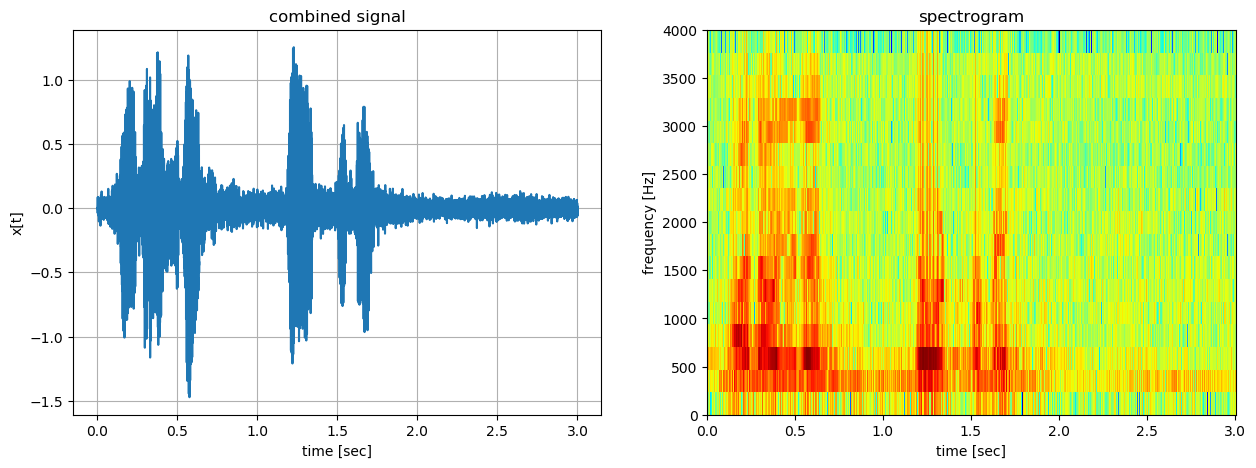

In [5]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_tot[1:length(t)])

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_tot, 32, 0, fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("combined signal"), ax[2].set_title("spectrogram")
;

## Specify generative model

In [6]:
# create factor graph
fg = FactorGraph()

# placeholders
z_min1 = Array{Variable,1}(undef, 2*length(freq))
γ1 = Array{Variable,1}(undef, 2*length(freq))
θ1 = Array{Variable,1}(undef, 2*length(freq))
z1 = Array{Variable,1}(undef, 2*length(freq))

# placeholders
z_min2 = Array{Variable,1}(undef, 2*length(freq))
γ2 = Array{Variable,1}(undef, 2*length(freq))
θ2 = Array{Variable,1}(undef, 2*length(freq))
z2 = Array{Variable,1}(undef, 2*length(freq))

# specify observation noise
@RV v ~ GaussianMeanVariance(zeros(buffer_size), var_observation*Ic(buffer_size))

# specify previous hidden state (spectral component buffer)
for k = 1:2*length(freq)
    @RV [id=pad(:z_min1,k)] z_min1[k] ~ GaussianMeanVariance(placeholder(pad(:μ_z_min1, k), dims = (AR_order,)),
                                        placeholder(pad(:Σ_z_min1, k), dims = (AR_order, AR_order)))
    @RV [id=pad(:γ1,k)] γ1[k] ~ ForneyLab.Gamma(placeholder(pad(:a_γ1,k)), placeholder(pad(:b_γ1,k)))
    @RV [id=pad(:θ1,k)] θ1[k] ~ GaussianMeanVariance(placeholder(pad(:μ_θ1,k), dims=(AR_order,)), placeholder(pad(:Σ_θ1,k), dims=(AR_order, AR_order)))
    @RV [id=pad(:z1,k)] z1[k] ~ LAR.Autoregressive(θ1[k], z_min1[k], γ1[k])
end

# specify previous hidden state (spectral component buffer)
for k = 1:2*length(freq)
    @RV [id=pad(:z_min2,k)] z_min2[k] ~ GaussianMeanVariance(placeholder(pad(:μ_z_min2, k), dims = (AR_order,)),
                                        placeholder(pad(:Σ_z_min2, k), dims = (AR_order, AR_order)))
    @RV [id=pad(:γ2,k)] γ2[k] ~ ForneyLab.Gamma(placeholder(pad(:a_γ2,k)), placeholder(pad(:b_γ2,k)))
    @RV [id=pad(:θ2,k)] θ2[k] ~ GaussianMeanVariance(placeholder(pad(:μ_θ2,k), dims=(AR_order,)), placeholder(pad(:Σ_θ2,k), dims=(AR_order, AR_order)))
    @RV [id=pad(:z2,k)] z2[k] ~ LAR.Autoregressive(θ2[k], z_min2[k], γ2[k])
end

# specify Fourier matrix
Ceme11 = Array{Variable,1}(undef, 2*length(freq))
Ceme12 = Array{Variable,1}(undef, 2*length(freq))
for k=1:2*length(freq)
    @RV Ceme11[k] 
    placeholder(Ceme11[k], pad(:Ceme11,k), dims = (buffer_size, AR_order))
    @RV Ceme12[k] 
    placeholder(Ceme12[k], pad(:Ceme12,k), dims = (buffer_size, AR_order))
end

# specify observations
@RV x1 = sum(Ceme11.*z1)

#@RV noisyx1 ~ GaussianMeanVariance(x1, var_x*Ic(buffer_size))

@RV x2 = sum(Ceme12.*z2)

#@RV noisyx2 ~ GaussianMeanVariance(x2, var_x*Ic(buffer_size))

@RV y = x1 + x2 + v

# create placeholder for observations
placeholder(y, :y, dims = (buffer_size,))

# draw factor graph
ForneyLab.draw(fg)
ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 3998391066266765937 -->
 3998391066266765937 
 
 × 
 multiplication_10 
 
<!-- 8636915008304026014 -->
 8636915008304026014 
 
 AR 
 autoregressive_10 
 
<!-- 3998391066266765937--8636915008304026014 -->
 3998391066266765937--8636915008304026014 
 
 z1_10 
 1 y 
 2 in1 
 
<!-- 13435042024108033203 -->
 13435042024108033203 
 
 placeholder_Ceme11_10 
 
<!-- 3998391066266765937--13435042024108033203 -->
 3998391066266765937--13435042024108033203 
 
 Ceme11_10 
 1 out 
 3 a 
 
<!-- 11523107374425211866 -->
 11523107374425211866 
 
 𝒩 
 gaussianmeanvariance_31 
 
<!-- 17289774055248389382 -->
 17289774055248389382 
 
 placeholder_μ_θ1_15 
 
<!-- 11523107374425211866--17289774055248389382 -->
 11523107374425211866--17289774055248389382 
 
 μ_θ1_15 
 1 out 
 2 m 
 
<!-- 13360217728091634977 -->
 13360217728091634977 
 
 placeholder_Σ_θ1_15 
 
<!-- 11523107374425211866--13360217728091634977 -->
 11523107374425211866--13360217728091634977 
 
 Σ_θ1_15 
 1 out 
 3 v 
 
<!-- 16128164924723714316 -->
 16128164924723714316 
 
 𝒩 
 gaussianmeanvariance_52 
 
<!-- 9989794245381562484 -->
 9989794245381562484 
 
 placeholder_μ_z_min1_26 
 
<!-- 16128164924723714316--9989794245381562484 -->
 16128164924723714316--9989794245381562484 
 
 μ_z_min1_26 
 1 out 
 2 m 
 
<!-- 5347832673905564060 -->
 5347832673905564060 
 
 placeholder_Σ_z_min1_26 
 
<!-- 16128164924723714316--5347832673905564060 -->
 16128164924723714316--5347832673905564060 
 
 Σ_z_min1_26 
 1 out 
 3 v 
 
<!-- 10833757200635037348 -->
 10833757200635037348 
 
 placeholder_b_γ1_08 
 
<!-- 7650402992372235563 -->
 7650402992372235563 
 
 × 
 multiplication_52 
 
<!-- 16143458867318595661 -->
 16143458867318595661 
 
 AR 
 autoregressive_52 
 
<!-- 7650402992372235563--16143458867318595661 -->
 7650402992372235563--16143458867318595661 
 
 z2_22 
 1 y 
 2 in1 
 
<!-- 17679627910445613770 -->
 17679627910445613770 
 
 placeholder_Ceme12_22 
 
<!-- 7650402992372235563--17679627910445613770 -->
 7650402992372235563--17679627910445613770 
 
 Ceme12_22 
 1 out 
 3 a 
 
<!-- 5452214215484073599 -->
 5452214215484073599 
 
 placeholder_a_γ1_23 
 
<!-- 6326874174273346990 -->
 6326874174273346990 
 
 𝒩 
 gaussianmeanvariance_121 
 
<!-- 820670798000617286 -->
 820670798000617286 
 
 placeholder_μ_θ2_30 
 
<!-- 6326874174273346990--820670798000617286 -->
 6326874174273346990--820670798000617286 
 
 μ_θ2_30 
 1 out 
 2 m 
 
<!-- 12146378240737868327 -->
 12146378240737868327 
 
 placeholder_Σ_θ2_30 
 
<!-- 6326874174273346990--12146378240737868327 -->
 6326874174273346990--12146378240737868327 
 
 Σ_θ2_30 
 1 out 
 3 v 
 
<!-- 17972836611648999164 -->
 17972836611648999164 
 
 𝒩 
 gaussianmeanvariance_84 
 
<!-- 159454752056049527 -->
 159454752056049527 
 
 placeholder_Σ_z_min2_12 
 
<!-- 17972836611648999164--159454752056049527 -->
 17972836611648999164--159454752056049527 
 
 Σ_z_min2_12 
 1 out 
 3 v 
 
<!-- 2439464923467945074 -->
 2439464923467945074 
 
 placeholder_μ_z_min2_12 
 
<!-- 17972836611648999164--2439464923467945074 -->
 17972836611648999164--2439464923467945074 
 
 μ_z_min2_12 
 1 out 
 2 m 
 
<!-- 8232942734037620224 -->
 8232942734037620224 
 
 placeholder_μ_θ1_24 
 
<!-- 13353482938441913763 -->
 13353482938441913763 
 
 AR 
 autoregressive_19 
 
<!-- 5878842216760973428 -->
 5878842216760973428 
 
 𝒩 
 gaussianmeanvariance_38 
 
<!-- 13353482938441913763--5878842216760973428 -->
 13353482938441913763--5878842216760973428 
 
 z_min1_19 
 1 out 
 2 x 
 
<!-- 14292510543102250774 -->
 14292510543

In [7]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(θ1, z1, z_min1, γ1, θ2, z2, z_min2, γ2, x1, x2, ids=[:θ1 :z1 :z_min1 :γ1 :θ2 :z2 :z_min2 :γ2 :x1 :x2])
algo = compatibility_fix(variationalAlgorithm(q))
# algo_F = freeEnergyAlgorithm(q) # throws error because the variables z are all connected

# evaluate algorithm
eval(Meta.parse(algo))
;

In [8]:
println(algo)

begin

function stepz_min2!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 60))

messages[1] = ruleVBGaussianMeanVarianceOut(nothing, ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:μ_z_min2_30]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Σ_z_min2_30]))
messages[2] = ruleVariationalARIn1PNPP(marginals[:z2_30], nothing, marginals[:θ2_30], marginals[:γ2_30])
messages[3] = ruleVBGaussianMeanVarianceOut(nothing, ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:μ_z_min2_29]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Σ_z_min2_29]))
messages[4] = ruleVariationalARIn1PNPP(marginals[:z2_29], nothing, marginals[:θ2_29], marginals[:γ2_29])
messages[5] = ruleVBGaussianMeanVarianceOut(nothing, ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:μ_z_min2_28]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Σ_z_min2_28]))
messages[6] = ruleVariationalARIn1PNPP(marginals

## Perform inference

In [9]:
messages=Array{Message}(undef, 500)
data = Dict()
marginals = Dict()

# create placeholders for priors
μ_z_min1 = Array{Array{Float64,1},1}(undef, 2*length(freq))
Σ_z_min1 = Array{Array{Float64,2},1}(undef, 2*length(freq))
μ_z_min2 = Array{Array{Float64,1},1}(undef, 2*length(freq))
Σ_z_min2 = Array{Array{Float64,2},1}(undef, 2*length(freq))

# set priors 
for k = 1:2*length(freq)
    μ_z_min1[k] = zeros(AR_order)
    Σ_z_min1[k] = 1e-10*Ic(AR_order)    
    μ_z_min2[k] = zeros(AR_order)
    Σ_z_min2[k] = 1e-10*Ic(AR_order)
end

# create marginals
for k = 1:2*length(freq)
    marginals[pad(:γ1, k)] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=params1[k]["a_gamma"], b=params1[k]["b_gamma"])
    marginals[pad(:θ1, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=params1[k]["mean_theta"], v=params1[k]["cov_theta"])
    marginals[pad(:z_min1, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_z_min1[k], v=Σ_z_min1[k])
    marginals[pad(:γ2, k)] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=params2[k]["a_gamma"], b=params2[k]["b_gamma"])
    marginals[pad(:θ2, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=params2[k]["mean_theta"], v=params2[k]["cov_theta"])
    marginals[pad(:z_min2, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_z_min2[k], v=Σ_z_min2[k])
end

# initialize buffer
buf = BufferData(x_tot[1:length(t)], t, buffer_size)

# initialize placeholder for hidden states and observation
μ_x1 = Array{Array{Float64,1},1}(undef, len(buf, step_size))
Σ_x1 = Array{Array{Float64,2},1}(undef, len(buf, step_size))
μ_x2 = Array{Array{Float64,1},1}(undef, len(buf, step_size))
Σ_x2 = Array{Array{Float64,2},1}(undef, len(buf, step_size))

# create progress bar
p = Progress(len(buf, step_size), 1, "Observed ")

# loop through samples
for k = 1:len(buf, step_size)
        
    # update progress bar
    update!(p, k)
    
    # fill data dictionary
    data[:y] = buf.buffer_s
    for f = 1:2*length(freq)
        data[pad(:Ceme11,f)] = calc_C(freq, buf.buffer_t)*em(2*length(freq), f)*(em(AR_order, 1)')
        data[pad(:Ceme12,f)] = calc_C(freq, buf.buffer_t)*em(2*length(freq), f)*(em(AR_order, 1)')
    end
    
    # infer parameters
    for it = 1:iterations
        
        # update data
        for f = 1:2*length(freq)
            data[pad(:a_γ1, f)] = params1[f]["a_gamma"]
            data[pad(:b_γ1, f)] = params1[f]["b_gamma"]
            data[pad(:μ_θ1, f)] = params1[f]["mean_theta"]
            data[pad(:Σ_θ1, f)] = 1e2*Ic(AR_order)#params1[f]["cov_theta"] 
            data[pad(:μ_z_min1, f)] = μ_z_min1[f]
            data[pad(:Σ_z_min1, f)] = Σ_z_min1[f]
           
            data[pad(:a_γ2, f)] = params2[f]["a_gamma"]
            data[pad(:b_γ2, f)] = params2[f]["b_gamma"]
            data[pad(:μ_θ2, f)] = params2[f]["mean_theta"]
            data[pad(:Σ_θ2, f)] = 1e2*Ic(AR_order)#params2[f]["cov_theta"]
            data[pad(:μ_z_min2, f)] = μ_z_min2[f]
            data[pad(:Σ_z_min2, f)] = Σ_z_min2[f]
        end
        
        # perform steps 
        marginals = Base.invokelatest(stepx1!, data, marginals, messages)  
        marginals = Base.invokelatest(stepx2!, data, marginals, messages)  
        marginals = Base.invokelatest(stepz1!, data, marginals, messages)  
        marginals = Base.invokelatest(stepz2!, data, marginals, messages)  
        marginals = Base.invokelatest(stepz_min1!, data, marginals, messages)
        marginals = Base.invokelatest(stepz_min2!, data, marginals, messages)
        marginals = Base.invokelatest(stepγ1!, data, marginals, messages)
        marginals = Base.invokelatest(stepγ2!, data, marginals, messages)
        marginals = Base.invokelatest(stepθ1!, data, marginals, messages)
        marginals = Base.invokelatest(stepθ2!, data, marginals, messages)

        # update hidden states
        for f = 1:2*length(freq)
            μ_z_min1[f] = ForneyLab.unsafeMean(marginals[pad(:z_min1,f)])
            Σ_z_min1[f] = ForneyLab.unsafeCov(marginals[pad(:z_min1,f)])            
            μ_z_min2[f] = ForneyLab.unsafeMean(marginals[pad(:z_min2,f)])
            Σ_z_min2[f] = ForneyLab.unsafeCov(marginals[pad(:z_min2,f)])
        end
    end
        
    # update hidden states
    for f = 1:2*length(freq)
        μ_z_min1[f] = ForneyLab.unsafeMean(marginals[pad(:z1,f)])
        Σ_z_min1[f] = ForneyLab.unsafeCov(marginals[pad(:z1,f)])            
        μ_z_min2[f] = ForneyLab.unsafeMean(marginals[pad(:z2,f)])
        Σ_z_min2[f] = ForneyLab.unsafeCov(marginals[pad(:z2,f)])
    end
    
    # fetch predictions
    if k > 0
        μ_x1[k] = ForneyLab.unsafeMean(marginals[:x1])
        Σ_x1[k] = ForneyLab.unsafeCov(marginals[:x1])
        μ_x2[k] = ForneyLab.unsafeMean(marginals[:x2])
        Σ_x2[k] = ForneyLab.unsafeCov(marginals[:x2])
    end
    
    # update buffer
    FLAG_data_remaining = step!(buf, step_size)
    
    
end

Observed   0%|█                                         |  ETA: 2 days, 17:23:43

ErrorException: PosDefException: Matrix is not positive-definite, even after regularization. Array{Float64,2}:
[6.326230882018908e14 7.288191361258056e14 6.326230882018914e14 7.288191361258008e14 6.326230882018874e14 7.288191361258044e14 6.326230882018832e14 7.288191361258059e14 6.326230882018872e14 7.288191361258098e14 6.326230882018784e14 7.288191361258184e14 6.326230882018726e14 7.288191361258175e14 6.32623088201874e14 7.288191361258132e14 6.326230882018901e14 7.288191361258031e14 6.326230882018904e14 7.288191361258049e14 6.326230882018855e14 7.288191361258085e14 6.326230882018746e14 7.288191361258168e14 6.326230882018745e14 7.288191361258199e14 6.326230882018726e14 7.288191361258214e14 6.326230882018714e14 7.288191361258169e14 6.326230882018748e14 7.288191361258144e14; 7.288191361258056e14 1.125899906842678e15 7.288191361258089e14 1.1258999068426622e15 7.288191361258141e14 1.1258999068426568e15 7.288191361258132e14 1.125899906842667e15 7.288191361258036e14 1.1258999068426815e15 7.28819136125795e14 1.1258999068426825e15 7.288191361257972e14 1.125899906842673e15 7.288191361257996e14 1.125899906842677e15 7.288191361258059e14 1.1258999068426738e15 7.288191361258071e14 1.1258999068426668e15 7.28819136125812e14 1.1258999068426635e15 7.288191361258005e14 1.1258999068426825e15 7.288191361257861e14 1.1258999068426958e15 7.28819136125786e14 1.125899906842687e15 7.288191361257949e14 1.1258999068426725e15 7.288191361258014e14 1.125899906842678e15; 6.326230882018914e14 7.288191361258089e14 6.326230882018979e14 7.288191361258045e14 6.326230882018899e14 7.28819136125808e14 6.326230882018894e14 7.2881913612581e14 6.326230882018892e14 7.288191361258142e14 6.326230882018834e14 7.28819136125823e14 6.326230882018742e14 7.288191361258212e14 6.326230882018785e14 7.288191361258171e14 6.32623088201892e14 7.288191361258068e14 6.32623088201896e14 7.288191361258084e14 6.326230882018876e14 7.288191361258128e14 6.326230882018805e14 7.288191361258211e14 6.326230882018765e14 7.288191361258245e14 6.326230882018774e14 7.288191361258255e14 6.326230882018725e14 7.288191361258214e14 6.326230882018801e14 7.288191361258181e14; 7.288191361258008e14 1.1258999068426622e15 7.288191361258045e14 1.1258999068426568e15 7.288191361258064e14 1.1258999068426568e15 7.28819136125805e14 1.12589990684266e15 7.288191361257999e14 1.125899906842668e15 7.288191361257916e14 1.125899906842676e15 7.288191361257892e14 1.1258999068426712e15 7.288191361257909e14 1.1258999068426698e15 7.288191361258019e14 1.12589990684266e15 7.288191361258029e14 1.1258999068426595e15 7.288191361258034e14 1.125899906842663e15 7.28819136125793e14 1.1258999068426765e15 7.288191361257829e14 1.1258999068426818e15 7.288191361257819e14 1.1258999068426792e15 7.28819136125787e14 1.1258999068426718e15 7.288191361257938e14 1.1258999068426708e15; 6.326230882018874e14 7.288191361258141e14 6.326230882018899e14 7.288191361258064e14 6.326230882019015e14 7.288191361258062e14 6.326230882018961e14 7.288191361258118e14 6.326230882018864e14 7.288191361258206e14 6.326230882018775e14 7.28819136125825e14 6.326230882018836e14 7.288191361258186e14 6.326230882018845e14 7.288191361258182e14 6.326230882018885e14 7.28819136125813e14 6.326230882018889e14 7.288191361258101e14 6.326230882018974e14 7.288191361258105e14 6.326230882018878e14 7.288191361258239e14 6.326230882018739e14 7.288191361258302e14 6.326230882018704e14 7.288191361258271e14 6.326230882018824e14 7.288191361258192e14 6.326230882018862e14 7.288191361258198e14; 7.288191361258044e14 1.1258999068426568e15 7.28819136125808e14 1.1258999068426568e15 7.288191361258062e14 1.1258999068426658e15 7.28819136125805e14 1.1258999068426615e15 7.288191361258034e14 1.1258999068426638e15 7.288191361257951e14 1.1258999068426768e15 7.288191361257884e14 1.1258999068426792e15 7.2881913612579e14 1.12589990684267e15 7.28819136125805e14 1.125899906842654e15 7.288191361258068e14 1.1258999068426605e15 7.288191361258032e14 1.1258999068426712e15 7.288191361257929e14 1.1258999068426778e15 7.288191361257866e14 1.125899906842677e15 7.288191361257852e14 1.1258999068426808e15 7.288191361257862e14 1.1258999068426795e15 7.288191361257926e14 1.125899906842671e15; 6.326230882018832e14 7.288191361258132e14 6.326230882018894e14 7.28819136125805e14 6.326230882018961e14 7.28819136125805e14 6.326230882018971e14 7.288191361258108e14 6.326230882018834e14 7.288191361258185e14 6.326230882018774e14 7.288191361258229e14 6.326230882018804e14 7.288191361258169e14 6.326230882018842e14 7.288191361258168e14 6.326230882018836e14 7.28819136125811e14 6.32623088201888e14 7.288191361258092e14 6.326230882018939e14 7.288191361258098e14 6.326230882018872e14 7.28819136125822e14 6.326230882018701e14 7.28819136125829e14 6.326230882018712e14 7.288191361258255e14 6.326230882018789e14 7.288191361258168e14 6.326230882018855e14 7.288191361258179e14; 7.288191361258059e14 1.125899906842667e15 7.2881913612581e14 1.12589990684266e15 7.288191361258118e14 1.1258999068426615e15 7.288191361258108e14 1.1258999068426675e15 7.288191361258049e14 1.125899906842674e15 7.288191361257955e14 1.1258999068426815e15 7.288191361257934e14 1.125899906842677e15 7.288191361257954e14 1.125899906842674e15 7.288191361258064e14 1.1258999068426635e15 7.288191361258082e14 1.1258999068426642e15 7.288191361258099e14 1.125899906842668e15 7.288191361257984e14 1.1258999068426815e15 7.288191361257876e14 1.125899906842688e15 7.288191361257869e14 1.1258999068426858e15 7.288191361257908e14 1.1258999068426762e15 7.288191361257975e14 1.1258999068426748e15; 6.326230882018872e14 7.288191361258036e14 6.326230882018892e14 7.288191361257999e14 6.326230882018864e14 7.288191361258034e14 6.326230882018834e14 7.288191361258049e14 6.326230882018886e14 7.288191361258082e14 6.326230882018785e14 7.288191361258162e14 6.326230882018719e14 7.288191361258148e14 6.326230882018716e14 7.288191361258108e14 6.326230882018876e14 7.288191361258015e14 6.32623088201888e14 7.288191361258039e14 6.32623088201884e14 7.288191361258082e14 6.326230882018742e14 7.288191361258161e14 6.326230882018746e14 7.288191361258186e14 6.326230882018725e14 7.288191361258191e14 6.326230882018702e14 7.288191361258145e14 6.32623088201873e14 7.28819136125812e14; 7.288191361258098e14 1.1258999068426815e15 7.288191361258142e14 1.125899906842668e15 7.288191361258206e14 1.1258999068426638e15 7.288191361258185e14 1.125899906842674e15 7.288191361258082e14 1.125899906842691e15 7.288191361257991e14 1.1258999068426902e15 7.288191361258004e14 1.1258999068426792e15 7.28819136125803e14 1.1258999068426828e15 7.288191361258106e14 1.125899906842679e15 7.288191361258129e14 1.1258999068426718e15 7.288191361258175e14 1.1258999068426695e15 7.288191361258066e14 1.1258999068426902e15 7.288191361257914e14 1.1258999068427038e15 7.288191361257895e14 1.1258999068426945e15 7.288191361257985e14 1.1258999068426795e15 7.288191361258052e14 1.1258999068426835e15; 6.326230882018784e14 7.28819136125795e14 6.326230882018834e14 7.288191361257916e14 6.326230882018775e14 7.288191361257951e14 6.326230882018774e14 7.288191361257955e14 6.326230882018785e14 7.288191361257991e14 6.326230882018749e14 7.288191361258071e14 6.326230882018634e14 7.288191361258052e14 6.326230882018668e14 7.288191361258022e14 6.326230882018794e14 7.288191361257935e14 6.326230882018826e14 7.288191361257951e14 6.326230882018741e14 7.288191361257991e14 6.326230882018689e14 7.288191361258076e14 6.326230882018661e14 7.28819136125809e14 6.32623088201867e14 7.288191361258095e14 6.326230882018621e14 7.28819136125806e14 6.326230882018688e14 7.288191361258032e14; 7.288191361258184e14 1.1258999068426825e15 7.28819136125823e14 1.125899906842676e15 7.28819136125825e14 1.1258999068426768e15 7.288191361258229e14 1.1258999068426815e15 7.288191361258162e14 1.1258999068426902e15 7.288191361258071e14 1.1258999068426998e15 7.288191361258048e14 1.1258999068426935e15 7.288191361258074e14 1.1258999068426912e15 7.288191361258196e14 1.1258999068426802e15 7.288191361258214e14 1.1258999068426792e15 7.288191361258219e14 1.1258999068426832e15 7.288191361258106e14 1.125899906842698e15 7.288191361257994e14 1.1258999068427042e15 7.288191361257975e14 1.1258999068427025e15 7.288191361258025e14 1.1258999068426942e15 7.2881913612581e14 1.125899906842692e15; 6.326230882018726e14 7.288191361257972e14 6.326230882018742e14 7.288191361257892e14 6.326230882018836e14 7.288191361257884e14 6.326230882018804e14 7.288191361257934e14 6.326230882018719e14 7.288191361258004e14 6.326230882018634e14 7.288191361258048e14 6.326230882018716e14 7.288191361257996e14 6.326230882018709e14 7.288191361258002e14 6.326230882018734e14 7.288191361257954e14 6.326230882018728e14 7.288191361257931e14 6.326230882018814e14 7.28819136125793e14 6.326230882018716e14 7.288191361258044e14 6.32623088201859e14 7.288191361258109e14 6.326230882018572e14 7.288191361258074e14 6.326230882018692e14 7.288191361257995e14 6.326230882018724e14 7.288191361258016e14; 7.288191361258175e14 1.125899906842673e15 7.288191361258212e14 1.1258999068426712e15 7.288191361258186e14 1.1258999068426792e15 7.288191361258169e14 1.125899906842677e15 7.288191361258148e14 1.1258999068426792e15 7.288191361258052e14 1.1258999068426935e15 7.288191361257996e14 1.125899906842698e15 7.288191361258024e14 1.1258999068426872e15 7.288191361258175e14 1.1258999068426698e15 7.288191361258195e14 1.1258999068426758e15 7.288191361258161e14 1.125899906842686e15 7.288191361258041e14 1.1258999068426928e15 7.28819136125797e14 1.1258999068426935e15 7.288191361257962e14 1.1258999068426982e15 7.288191361257969e14 1.1258999068426968e15 7.288191361258041e14 1.125899906842688e15; 6.32623088201874e14 7.288191361257996e14 6.326230882018785e14 7.288191361257909e14 6.326230882018845e14 7.2881913612579e14 6.326230882018842e14 7.288191361257954e14 6.326230882018716e14 7.28819136125803e14 6.326230882018668e14 7.288191361258074e14 6.326230882018709e14 7.288191361258024e14 6.326230882018761e14 7.288191361258028e14 6.32623088201874e14 7.28819136125797e14 6.326230882018776e14 7.288191361257951e14 6.326230882018825e14 7.288191361257945e14 6.326230882018756e14 7.288191361258062e14 6.32623088201859e14 7.288191361258129e14 6.326230882018611e14 7.288191361258101e14 6.326230882018696e14 7.28819136125802e14 6.326230882018764e14 7.288191361258039e14; 7.288191361258132e14 1.125899906842677e15 7.288191361258171e14 1.1258999068426698e15 7.288191361258182e14 1.12589990684267e15 7.288191361258168e14 1.125899906842674e15 7.288191361258108e14 1.1258999068426828e15 7.288191361258022e14 1.1258999068426912e15 7.288191361258002e14 1.1258999068426872e15 7.288191361258028e14 1.125899906842686e15 7.288191361258138e14 1.1258999068426745e15 7.288191361258151e14 1.125899906842674e15 7.288191361258155e14 1.1258999068426768e15 7.28819136125804e14 1.1258999068426902e15 7.288191361257932e14 1.1258999068426968e15 7.288191361257922e14 1.1258999068426955e15 7.288191361257979e14 1.1258999068426872e15 7.288191361258049e14 1.1258999068426862e15; 6.326230882018901e14 7.288191361258059e14 6.32623088201892e14 7.288191361258019e14 6.326230882018885e14 7.28819136125805e14 6.326230882018836e14 7.288191361258064e14 6.326230882018876e14 7.288191361258106e14 6.326230882018794e14 7.288191361258196e14 6.326230882018734e14 7.288191361258175e14 6.32623088201874e14 7.288191361258138e14 6.326230882018922e14 7.288191361258041e14 6.326230882018912e14 7.28819136125805e14 6.326230882018859e14 7.288191361258091e14 6.326230882018758e14 7.288191361258176e14 6.326230882018756e14 7.288191361258202e14 6.326230882018731e14 7.288191361258214e14 6.326230882018722e14 7.288191361258181e14 6.326230882018762e14 7.28819136125815e14; 7.288191361258031e14 1.1258999068426738e15 7.288191361258068e14 1.12589990684266e15 7.28819136125813e14 1.125899906842654e15 7.28819136125811e14 1.1258999068426635e15 7.288191361258015e14 1.125899906842679e15 7.288191361257935e14 1.1258999068426802e15 7.288191361257954e14 1.1258999068426698e15 7.28819136125797e14 1.1258999068426745e15 7.288191361258041e14 1.1258999068426728e15 7.288191361258051e14 1.125899906842664e15 7.288191361258091e14 1.1258999068426608e15 7.288191361257986e14 1.1258999068426808e15 7.288191361257841e14 1.1258999068426932e15 7.288191361257832e14 1.1258999068426845e15 7.288191361257926e14 1.1258999068426708e15 7.288191361257999e14 1.1258999068426752e15; 6.326230882018904e14 7.288191361258071e14 6.32623088201896e14 7.288191361258029e14 6.326230882018889e14 7.288191361258068e14 6.32623088201888e14 7.288191361258082e14 6.32623088201888e14 7.288191361258129e14 6.326230882018826e14 7.288191361258214e14 6.326230882018728e14 7.288191361258195e14 6.326230882018776e14 7.288191361258151e14 6.326230882018912e14 7.288191361258051e14 6.326230882018961e14 7.288191361258062e14 6.326230882018868e14 7.288191361258104e14 6.326230882018802e14 7.288191361258194e14 6.326230882018761e14 7.288191361258222e14 6.326230882018766e14 7.288191361258236e14 6.326230882018721e14 7.288191361258194e14 6.326230882018792e14 7.288191361258165e14; 7.288191361258049e14 1.1258999068426668e15 7.288191361258084e14 1.1258999068426595e15 7.288191361258101e14 1.1258999068426605e15 7.288191361258092e14 1.1258999068426642e15 7.288191361258039e14 1.1258999068426718e15 7.288191361257951e14 1.1258999068426792e15 7.288191361257931e14 1.1258999068426758e15 7.288191361257951e14 1.125899906842674e15 7.28819136125805e14 1.125899906842664e15 7.288191361258062e14 1.1258999068426652e15 7.28819136125807e14 1.1258999068426675e15 7.28819136125796e14 1.1258999068426808e15 7.28819136125786e14 1.1258999068426865e15 7.288191361257855e14 1.1258999068426845e15 7.288191361257904e14 1.1258999068426758e15 7.288191361257968e14 1.1258999068426748e15; 6.326230882018855e14 7.28819136125812e14 6.326230882018876e14 7.288191361258034e14 6.326230882018974e14 7.288191361258032e14 6.326230882018939e14 7.288191361258099e14 6.32623088201884e14 7.288191361258175e14 6.326230882018741e14 7.288191361258219e14 6.326230882018814e14 7.288191361258161e14 6.326230882018825e14 7.288191361258155e14 6.326230882018859e14 7.288191361258091e14 6.326230882018868e14 7.28819136125807e14 6.326230882018971e14 7.288191361258074e14 6.326230882018856e14 7.288191361258198e14 6.326230882018719e14 7.288191361258274e14 6.326230882018694e14 7.288191361258242e14 6.326230882018802e14 7.288191361258155e14 6.326230882018839e14 7.288191361258165e14; 7.288191361258085e14 1.1258999068426635e15 7.288191361258128e14 1.125899906842663e15 7.288191361258105e14 1.1258999068426712e15 7.288191361258098e14 1.125899906842668e15 7.288191361258082e14 1.1258999068426695e15 7.288191361257991e14 1.1258999068426832e15 7.28819136125793e14 1.125899906842686e15 7.288191361257945e14 1.1258999068426768e15 7.288191361258091e14 1.1258999068426608e15 7.288191361258104e14 1.1258999068426675e15 7.288191361258074e14 1.1258999068426795e15 7.288191361257965e14 1.1258999068426848e15 7.288191361257901e14 1.1258999068426845e15 7.288191361257896e14 1.1258999068426882e15 7.2881913612579e14 1.125899906842686e15 7.288191361257965e14 1.1258999068426778e15; 6.326230882018746e14 7.288191361258005e14 6.326230882018805e14 7.28819136125793e14 6.326230882018878e14 7.288191361257929e14 6.326230882018872e14 7.288191361257984e14 6.326230882018742e14 7.288191361258066e14 6.326230882018689e14 7.288191361258106e14 6.326230882018716e14 7.288191361258041e14 6.326230882018756e14 7.28819136125804e14 6.326230882018758e14 7.288191361257986e14 6.326230882018802e14 7.28819136125796e14 6.326230882018856e14 7.288191361257965e14 6.326230882018805e14 7.288191361258091e14 6.326230882018628e14 7.288191361258156e14 6.326230882018631e14 7.288191361258125e14 6.326230882018709e14 7.288191361258042e14 6.326230882018775e14 7.288191361258052e14; 7.288191361258168e14 1.1258999068426825e15 7.288191361258211e14 1.1258999068426765e15 7.288191361258239e14 1.1258999068426778e15 7.28819136125822e14 1.1258999068426815e15 7.288191361258161e14 1.1258999068426902e15 7.288191361258076e14 1.125899906842698e15 7.288191361258044e14 1.1258999068426928e15 7.288191361258062e14 1.1258999068426902e15 7.288191361258176e14 1.1258999068426808e15 7.288191361258194e14 1.1258999068426808e15 7.288191361258198e14 1.1258999068426848e15 7.288191361258091e14 1.1258999068427005e15 7.288191361257985e14 1.1258999068427048e15 7.288191361257969e14 1.1258999068427022e15 7.288191361258019e14 1.1258999068426935e15 7.288191361258088e14 1.1258999068426912e15; 6.326230882018745e14 7.288191361257861e14 6.326230882018765e14 7.288191361257829e14 6.326230882018739e14 7.288191361257866e14 6.326230882018701e14 7.288191361257876e14 6.326230882018746e14 7.288191361257914e14 6.326230882018661e14 7.288191361257994e14 6.32623088201859e14 7.28819136125797e14 6.32623088201859e14 7.288191361257932e14 6.326230882018756e14 7.288191361257841e14 6.326230882018761e14 7.28819136125786e14 6.326230882018719e14 7.288191361257901e14 6.326230882018628e14 7.288191361257985e14 6.326230882018639e14 7.288191361258006e14 6.326230882018602e14 7.28819136125801e14 6.326230882018584e14 7.288191361257972e14 6.326230882018609e14 7.288191361257945e14; 7.288191361258199e14 1.1258999068426958e15 7.288191361258245e14 1.1258999068426818e15 7.288191361258302e14 1.125899906842677e15 7.28819136125829e14 1.125899906842688e15 7.288191361258186e14 1.1258999068427038e15 7.28819136125809e14 1.1258999068427042e15 7.288191361258109e14 1.1258999068426935e15 7.288191361258129e14 1.1258999068426968e15 7.288191361258202e14 1.1258999068426932e15 7.288191361258222e14 1.1258999068426865e15 7.288191361258274e14 1.1258999068426845e15 7.288191361258156e14 1.1258999068427048e15 7.288191361258006e14 1.1258999068427198e15 7.288191361257992e14 1.1258999068427092e15 7.288191361258078e14 1.1258999068426938e15 7.288191361258151e14 1.1258999068426978e15; 6.326230882018726e14 7.28819136125786e14 6.326230882018774e14 7.288191361257819e14 6.326230882018704e14 7.288191361257852e14 6.326230882018712e14 7.288191361257869e14 6.326230882018725e14 7.288191361257895e14 6.32623088201867e14 7.288191361257975e14 6.326230882018572e14 7.288191361257962e14 6.326230882018611e14 7.288191361257922e14 6.326230882018731e14 7.288191361257832e14 6.326230882018766e14 7.288191361257855e14 6.326230882018694e14 7.288191361257896e14 6.326230882018631e14 7.288191361257969e14 6.326230882018602e14 7.288191361257992e14 6.32623088201863e14 7.288191361257998e14 6.326230882018562e14 7.288191361257955e14 6.326230882018624e14 7.288191361257938e14; 7.288191361258214e14 1.125899906842687e15 7.288191361258255e14 1.1258999068426792e15 7.288191361258271e14 1.1258999068426808e15 7.288191361258255e14 1.1258999068426858e15 7.288191361258191e14 1.1258999068426945e15 7.288191361258095e14 1.1258999068427025e15 7.288191361258074e14 1.1258999068426982e15 7.288191361258101e14 1.1258999068426955e15 7.288191361258214e14 1.1258999068426845e15 7.288191361258236e14 1.1258999068426845e15 7.288191361258242e14 1.1258999068426882e15 7.288191361258125e14 1.1258999068427022e15 7.28819136125801e14 1.1258999068427092e15 7.288191361257998e14 1.1258999068427082e15 7.288191361258045e14 1.1258999068426982e15 7.288191361258119e14 1.1258999068426965e15; 6.326230882018714e14 7.288191361257949e14 6.326230882018725e14 7.28819136125787e14 6.326230882018824e14 7.288191361257862e14 6.326230882018789e14 7.288191361257908e14 6.326230882018702e14 7.288191361257985e14 6.326230882018621e14 7.288191361258025e14 6.326230882018692e14 7.288191361257969e14 6.326230882018696e14 7.288191361257979e14 6.326230882018722e14 7.288191361257926e14 6.326230882018721e14 7.288191361257904e14 6.326230882018802e14 7.2881913612579e14 6.326230882018709e14 7.288191361258019e14 6.326230882018584e14 7.288191361258078e14 6.326230882018562e14 7.288191361258045e14 6.326230882018691e14 7.28819136125797e14 6.326230882018712e14 7.288191361257989e14; 7.288191361258169e14 1.1258999068426725e15 7.288191361258214e14 1.1258999068426718e15 7.288191361258192e14 1.1258999068426795e15 7.288191361258168e14 1.1258999068426762e15 7.288191361258145e14 1.1258999068426795e15 7.28819136125806e14 1.1258999068426942e15 7.288191361257995e14 1.1258999068426968e15 7.28819136125802e14 1.1258999068426872e15 7.288191361258181e14 1.1258999068426708e15 7.288191361258194e14 1.1258999068426758e15 7.288191361258155e14 1.125899906842686e15 7.288191361258042e14 1.1258999068426935e15 7.288191361257972e14 1.1258999068426938e15 7.288191361257955e14 1.1258999068426982e15 7.28819136125797e14 1.1258999068426985e15 7.288191361258046e14 1.1258999068426882e15; 6.326230882018748e14 7.288191361258014e14 6.326230882018801e14 7.288191361257938e14 6.326230882018862e14 7.288191361257926e14 6.326230882018855e14 7.288191361257975e14 6.32623088201873e14 7.288191361258052e14 6.326230882018688e14 7.2881913612581e14 6.326230882018724e14 7.288191361258041e14 6.326230882018764e14 7.288191361258049e14 6.326230882018762e14 7.288191361257999e14 6.326230882018792e14 7.288191361257968e14 6.326230882018839e14 7.288191361257965e14 6.326230882018775e14 7.288191361258088e14 6.326230882018609e14 7.288191361258151e14 6.326230882018624e14 7.288191361258119e14 6.326230882018712e14 7.288191361258046e14 6.326230882018792e14 7.288191361258061e14; 7.288191361258144e14 1.125899906842678e15 7.288191361258181e14 1.1258999068426708e15 7.288191361258198e14 1.125899906842671e15 7.288191361258179e14 1.1258999068426748e15 7.28819136125812e14 1.1258999068426835e15 7.288191361258032e14 1.125899906842692e15 7.288191361258016e14 1.125899906842688e15 7.288191361258039e14 1.1258999068426862e15 7.28819136125815e14 1.1258999068426752e15 7.288191361258165e14 1.1258999068426748e15 7.288191361258165e14 1.1258999068426778e15 7.288191361258052e14 1.1258999068426912e15 7.288191361257945e14 1.1258999068426978e15 7.288191361257938e14 1.1258999068426965e15 7.288191361257989e14 1.1258999068426882e15 7.288191361258061e14 1.1258999068426875e15]

In [10]:
# convert μ_x to a 1d array
μ_x_pred = expand(reverse(hcat(μ_x...),dims=1))

# convert s_x to a 2d array
if length(size(μ_s)) != 2
    μ_s = hcat(μ_s...)
end

# calculate magnitude spectrum
mag_μ_s = log10.((μ_s[1:length(freq),:].^2 + μ_s[length(freq)+1:end,:].^2))


# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
cmp = ax[1].imshow(mag_μ_s,
                   aspect="auto",
                   cmap="jet",
                   origin="lower",
                   extent=[minimum(t), maximum(t), 1, length(freq)])
fig.colorbar(cmp, ax=ax[1])

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 2*length(freq)+1, 0, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)

# change visuals
ax[1].set_xlim(minimum(t), maximum(t)), ax[2].set_ylim(minimum(freq), maximum(freq)), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency [Hz]"), ax[1].set_title("Predicted spectrum"), ax[2].set_title("STFT spectrum")
#cmp.set_clim(-3, -16)
;

UndefVarError: UndefVarError: μ_x not defined

In [11]:
# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
μ_x_pred_norm = μ_x_pred/maximum(μ_x_pred)
println(var(μ_x_pred))
μ_x_pred_select = μ_x_pred[1:Int(buffer_size/step_size):end]

# plot actual, noisy and marginal of frequency component
ax[1].plot(t, x_time, label="true"), ax[1].plot(t[1:length(μ_x_pred_select)], μ_x_pred_select, label="prediction")#, ax[1].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")
ax[2].plot(t, x_time, label="true"), ax[2].plot(t[1:length(μ_x_pred_select)], μ_x_pred_select, label="prediction")#, ax[2].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")

# change vizualization
ax[1].grid(), ax[1].set_xlim(0,3), ax[1].set_ylim(-1.5, 1.5), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("x[t]"), ax[1].legend()
ax[2].grid(), ax[2].set_xlim(0.55,0.56), ax[2].set_ylim(-1, 1), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("x[t]"), ax[2].legend()

# create audioplayers
audioplayers(x_time, μ_x_pred_select, μ_x_pred_norm, fs=fs_desired)
;

UndefVarError: UndefVarError: μ_x_pred not defined

##### Performance metrics

In [12]:
MSE = 1/length(μ_x_pred_select) * sum(abs.(μ_x_pred_select - x_time[1:length(μ_x_pred_select)]).^2)

UndefVarError: UndefVarError: μ_x_pred_select not defined

In [13]:
MAE = 1/length(μ_x_pred_select) * sum(abs.(μ_x_pred_select - x_time[1:length(μ_x_pred_select)]))

UndefVarError: UndefVarError: μ_x_pred_select not defined

In [14]:
using Distributions;
logBME = Float64[]
# initialize buffer
buf = BufferData(x_time, t, buffer_size)
for k = 1:length(μ_x)
    try 
        push!(logBME, logpdf(Distributions.Normal(μ_x[k][1], Σ_x[k][1,1]), buf.buffer_s[1]))
    catch
    end
    step!(buf, step_size)
end
print("nr: "* string(length(logBME))* "       mean:"* string(mean(logBME)))

UndefVarError: UndefVarError: x_time not defined

In [15]:
μ_x_pred1_first = [μ_x1[k][1] for k = 1:length(μ_x1)]
μ_x_pred2_first = [μ_x2[k][1] for k = 1:length(μ_x2)]
μ_x_pred1_last = [μ_x1[k][end] for k = 1:length(μ_x1)]
μ_x_pred2_last = [μ_x2[k][end] for k = 1:length(μ_x2)]
;

UndefRefError: UndefRefError: access to undefined reference

In [16]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t[1:length(μ_x_pred1_first)], μ_x_pred1_first)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(μ_x_pred1_first, 2*length(freq), 0, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("combined signal"), ax[2].set_title("spectrogram")

#plt.plot(μ_x_pred1_first)
audioplayers(x_time1, x_time2, x_tot, μ_x_pred1_first, fs=fs_desired)
;

UndefVarError: UndefVarError: μ_x_pred1_first not defined

In [17]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t[1:length(μ_x_pred2_first)], μ_x_pred2_first)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(μ_x_pred2_first, 2*length(freq), 0, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("combined signal"), ax[2].set_title("spectrogram")

#plt.plot(μ_x_pred1_first)
audioplayers(x_time1, x_time2, x_tot, μ_x_pred2_first, fs=fs_desired)
;

UndefVarError: UndefVarError: μ_x_pred2_first not defined

In [18]:
plt.plot(μ_x_pred1_last)
audioplayers(x_time1, x_time2, x_tot, μ_x_pred1_last, fs=fs_desired)

UndefVarError: UndefVarError: μ_x_pred1_last not defined

In [19]:
plt.plot(μ_x_pred2_last)
audioplayers(x_time1, x_time2, x_tot, μ_x_pred2_last, fs=fs_desired)

UndefVarError: UndefVarError: μ_x_pred2_last not defined

In [20]:
params1[bin]["a_gamma"], params2[bin]["b_gamma"], plt.stem([log.(params1[bin]["a_gamma"]/params1[bin]["b_gamma"]) for bin = 1:2*length(freq)])

UndefVarError: UndefVarError: bin not defined

In [21]:
params1[bin]["a_gamma"], params2[bin]["b_gamma"], plt.stem([log.(params2[bin]["a_gamma"]/params2[bin]["b_gamma"]) for bin = 1:2*length(freq)])

UndefVarError: UndefVarError: bin not defined

In [22]:
pred = [μ_x1[k][1] for k=1:length(μ_x1) if isassigned(μ_x1, k)]

7-element Array{Float64,1}:
  0.0                  
  0.011771984546014469 
  0.04338868023227471  
  0.04514538759080011  
 -0.0043245198137897845
 -0.0180223977395233   
 -0.02416372905687547  

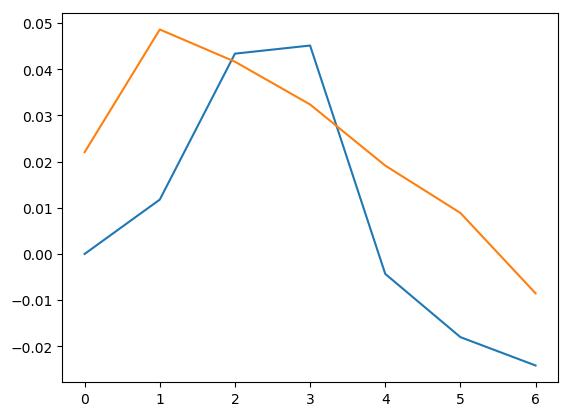

(PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x00000000352470F0>], PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x0000000035247438>])

In [23]:
plt.plot(pred), plt.plot(x_time1[1:length(pred)])

In [24]:
marginals

Dict{Any,Any} with 243 entries:
  :θ1_10     => 𝒩(xi=[-8.09e-04, 1.79e-03, -6.15e-03, 8.39e-03, -3.23e-03], w=[…
  :θ1_13     => 𝒩(xi=[7.91e-05, -9.72e-03, 0.01, 4.83e-04, -2.30e-03], w=[[0.01…
  :γ1_07     => Gam(a=3.60e+04, b=3.42e+03)…
  :z2_11     => 𝒩(xi=[-1.24e-03, -0.01, -9.28e-03, -3.72e-03, -1.82e-03], w=[[1…
  :θ1_08     => 𝒩(xi=[5.48e-03, 6.93e-03, 2.09e-03, -9.51e-04, -0.01], w=[[0.01…
  :γ1_11     => Gam(a=3.60e+04, b=6.99e+04)…
  :θ2_18     => 𝒩(xi=[-6.75e-03, 0.02, -6.26e-03, -6.67e-03, 2.71e-03], w=[[0.0…
  :z_min1_24 => 𝒩(xi=[-0.25, -0.27, -0.18, -0.09, -6.57e-03], w=[[5.00e+12, 3.4…
  :z_min1_19 => 𝒩(xi=[-0.04, 1.33e-03, -0.02, -0.01, 3.65e-04], w=[[5.00e+12, -…
  :θ2_14     => 𝒩(xi=[0.02, 2.86e-03, -5.04e-03, -0.02, 5.51e-03], w=[[0.01, 9.…
  :θ1_20     => 𝒩(xi=[-5.85e-03, 4.04e-03, 7.03e-03, -2.93e-03, -2.29e-03], w=[…
  :θ2_04     => 𝒩(xi=[-0.01, -3.00e-04, 0.01, -4.76e-03, 4.50e-03], w=[[0.01, -…
  :γ2_15     => Gam(a=3.60e+04, b=2.08e+04)…
  :z1_30     => 𝒩(xi=[-